In [11]:
from typing import Union

import numpy as np
import pandas as pd
import torch
from torch import nn
from torch import optim
import torch.optim.lr_scheduler as lr_scheduler
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.decomposition

from lib.data_preprocessing import remove_correlated_columns, normalize_data
from lib.ds.bird_classes import NUM_CLASSES
from lib.ds.dataset_loading import load_all_data, flatten
from lib.ds.dataset_splitting import split
from lib.ds.torch_dataset import create_data_loader
from lib.ds.challenge_dataset import load_challenge_data
from lib.model.attention_classifier import AttentionClassifier, AttentionClassifierHyperParameters
from lib.torch_generic_model_training import train_model_with_cv
from lib.training_hyper_parameters import TrainingHyperParameters
from lib.ds.numpy_dataset import NumpyDataset
from lib.model.model_persistence import save_model, load_model
from lib.random import set_random_seed
from lib.metrics import calculate_average_metrics_for_final_epoch_of_folds, calculate_average_metrics_per_epoch, calculate_average_metrics
from lib.ds.bird_combiner import combine_birds
from lib.challenge import predict_for_challenge, save_results_to_csv, load_results_from_csv
from lib.label_fixing import fix_labels_information_gain
import lib.torch_device as tdev

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
# tdev.PREFERRED = 'cpu'
device = tdev.get_torch_device()
device

device(type='cuda', index=0)

In [5]:
data_raw, labels = load_all_data('dataset')
print(f'{data_raw.shape = }')
print(f'{labels.shape   = }')

data_raw.shape = (1200, 100, 548)
labels.shape   = (1200, 100)


In [6]:
combined_ds = combine_birds(
    NumpyDataset(data_raw, labels), 
    sequence_length=300,
    random_seed=42
)
print(f'{combined_ds.data.shape = }')
print(f'{combined_ds.labels.shape = }')

Creating random sequence from 1 duplicates: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 120000/120000 [02:05<00:00, 953.92it/s]

combined_ds.data.shape = (400, 300, 548)
combined_ds.labels.shape = (400, 300)


# Hyper Parameters

In [9]:
ac_hyper_parameters = AttentionClassifierHyperParameters(
    in_features=data_raw.shape[-1],
    out_features=NUM_CLASSES,
    
    attention_window_size=30,
    d_model=60,
    num_heads=12,
    attention_stack_size=1,
    attention_stack_activation_provider=lambda: nn.LeakyReLU(),
    attention_dropout=0.45,
    
    in_linear_hidden_out_features=[64, 48],
    out_linear_hidden_out_features=[24, 16],
    linear_activation_provider=lambda: nn.LeakyReLU(),
    linear_dropout=0.45,
)

In [8]:
def create_training_hyper_parameters(
    num_epochs: Union[int, float], 
    initial_lr: float,
    lr_scheduler_milestones: list[Union[int, float]],
    lr_scheduler_gamma: float
):
    return TrainingHyperParameters(
        batch_size=32,
        
        loss_weight_factors=torch.Tensor([
            1.0 / 1.35, # 0
            1.0, # 1
            1.0 / 1.5, # 2
            1.0, # 3
            1.0, # 4
            1.0, # 5
            1.0, # 6
        ]).to(device),
        
        optimizer_provider=lambda model, lr: optim.Adamax(
            model.parameters(),
            lr=lr,
            betas=(0.9, 0.98),
            eps=1e-9
        ),

        num_epochs=int(num_epochs),
        
        lr=initial_lr,
        lr_scheduler_milestones=[int(m) for m in lr_scheduler_milestones],
        lr_scheduler_gamma=lr_scheduler_gamma,
        lr_scheduler_provider=lambda optimizer, milestones, gamma: None,
        # lr_scheduler_provider=lambda optimizer, milestones, gamma: lr_scheduler.MultiStepLR(
        #     optimizer, 
        #     milestones=milestones,
        #     gamma=gamma
        # )
    )

# Training

## Cross Validation

Creating 8 folds


CV Folds:   0%|                                                                                                                                                                                | 0/8 [00:00<?, ?it/s]

Executing CV for fold 0
Training fold 0


#### Training ####
##################
AttentionClassifier with 57819 parameters, in_fnn: 41196, attention_stack: 14640, out_fnn: 1983
##################

train label counts = [74723, 5039, 7801, 7154, 2028, 4523, 3732]
loss weights = [0.74, 14.83, 6.39, 10.44, 36.85, 16.52, 20.02]

eval label counts = [10635, 794, 1153, 1044, 296, 588, 490]
eval loss weights (theoretical) = [0.74, 13.39, 6.15, 10.19, 35.93, 18.09, 21.7]


Training Epoch   1/300: lr = 1.00E-03, epoch =     1, avg_loss = 0.000204, num_samples = 105000, num_correct =  2804, acc = 0.026705, bacc = 0.139801, score = -0.438340
Evaluation Epoch   1/300: epoch =     1, avg_loss = 0.000276, num_samples = 15000, num_correct =   356, acc = 0.023733, bacc = 0.134363, score = -0.443539
Training Epoch   2/300: lr = 1.00E-03, epoch =     2, avg_loss = 0.000203, num_samples = 105000, num_correct =  2266, acc = 0.021581, bacc = 0.142190, score = -0.455109
Evaluation Epoch   2/300: epoch =     2

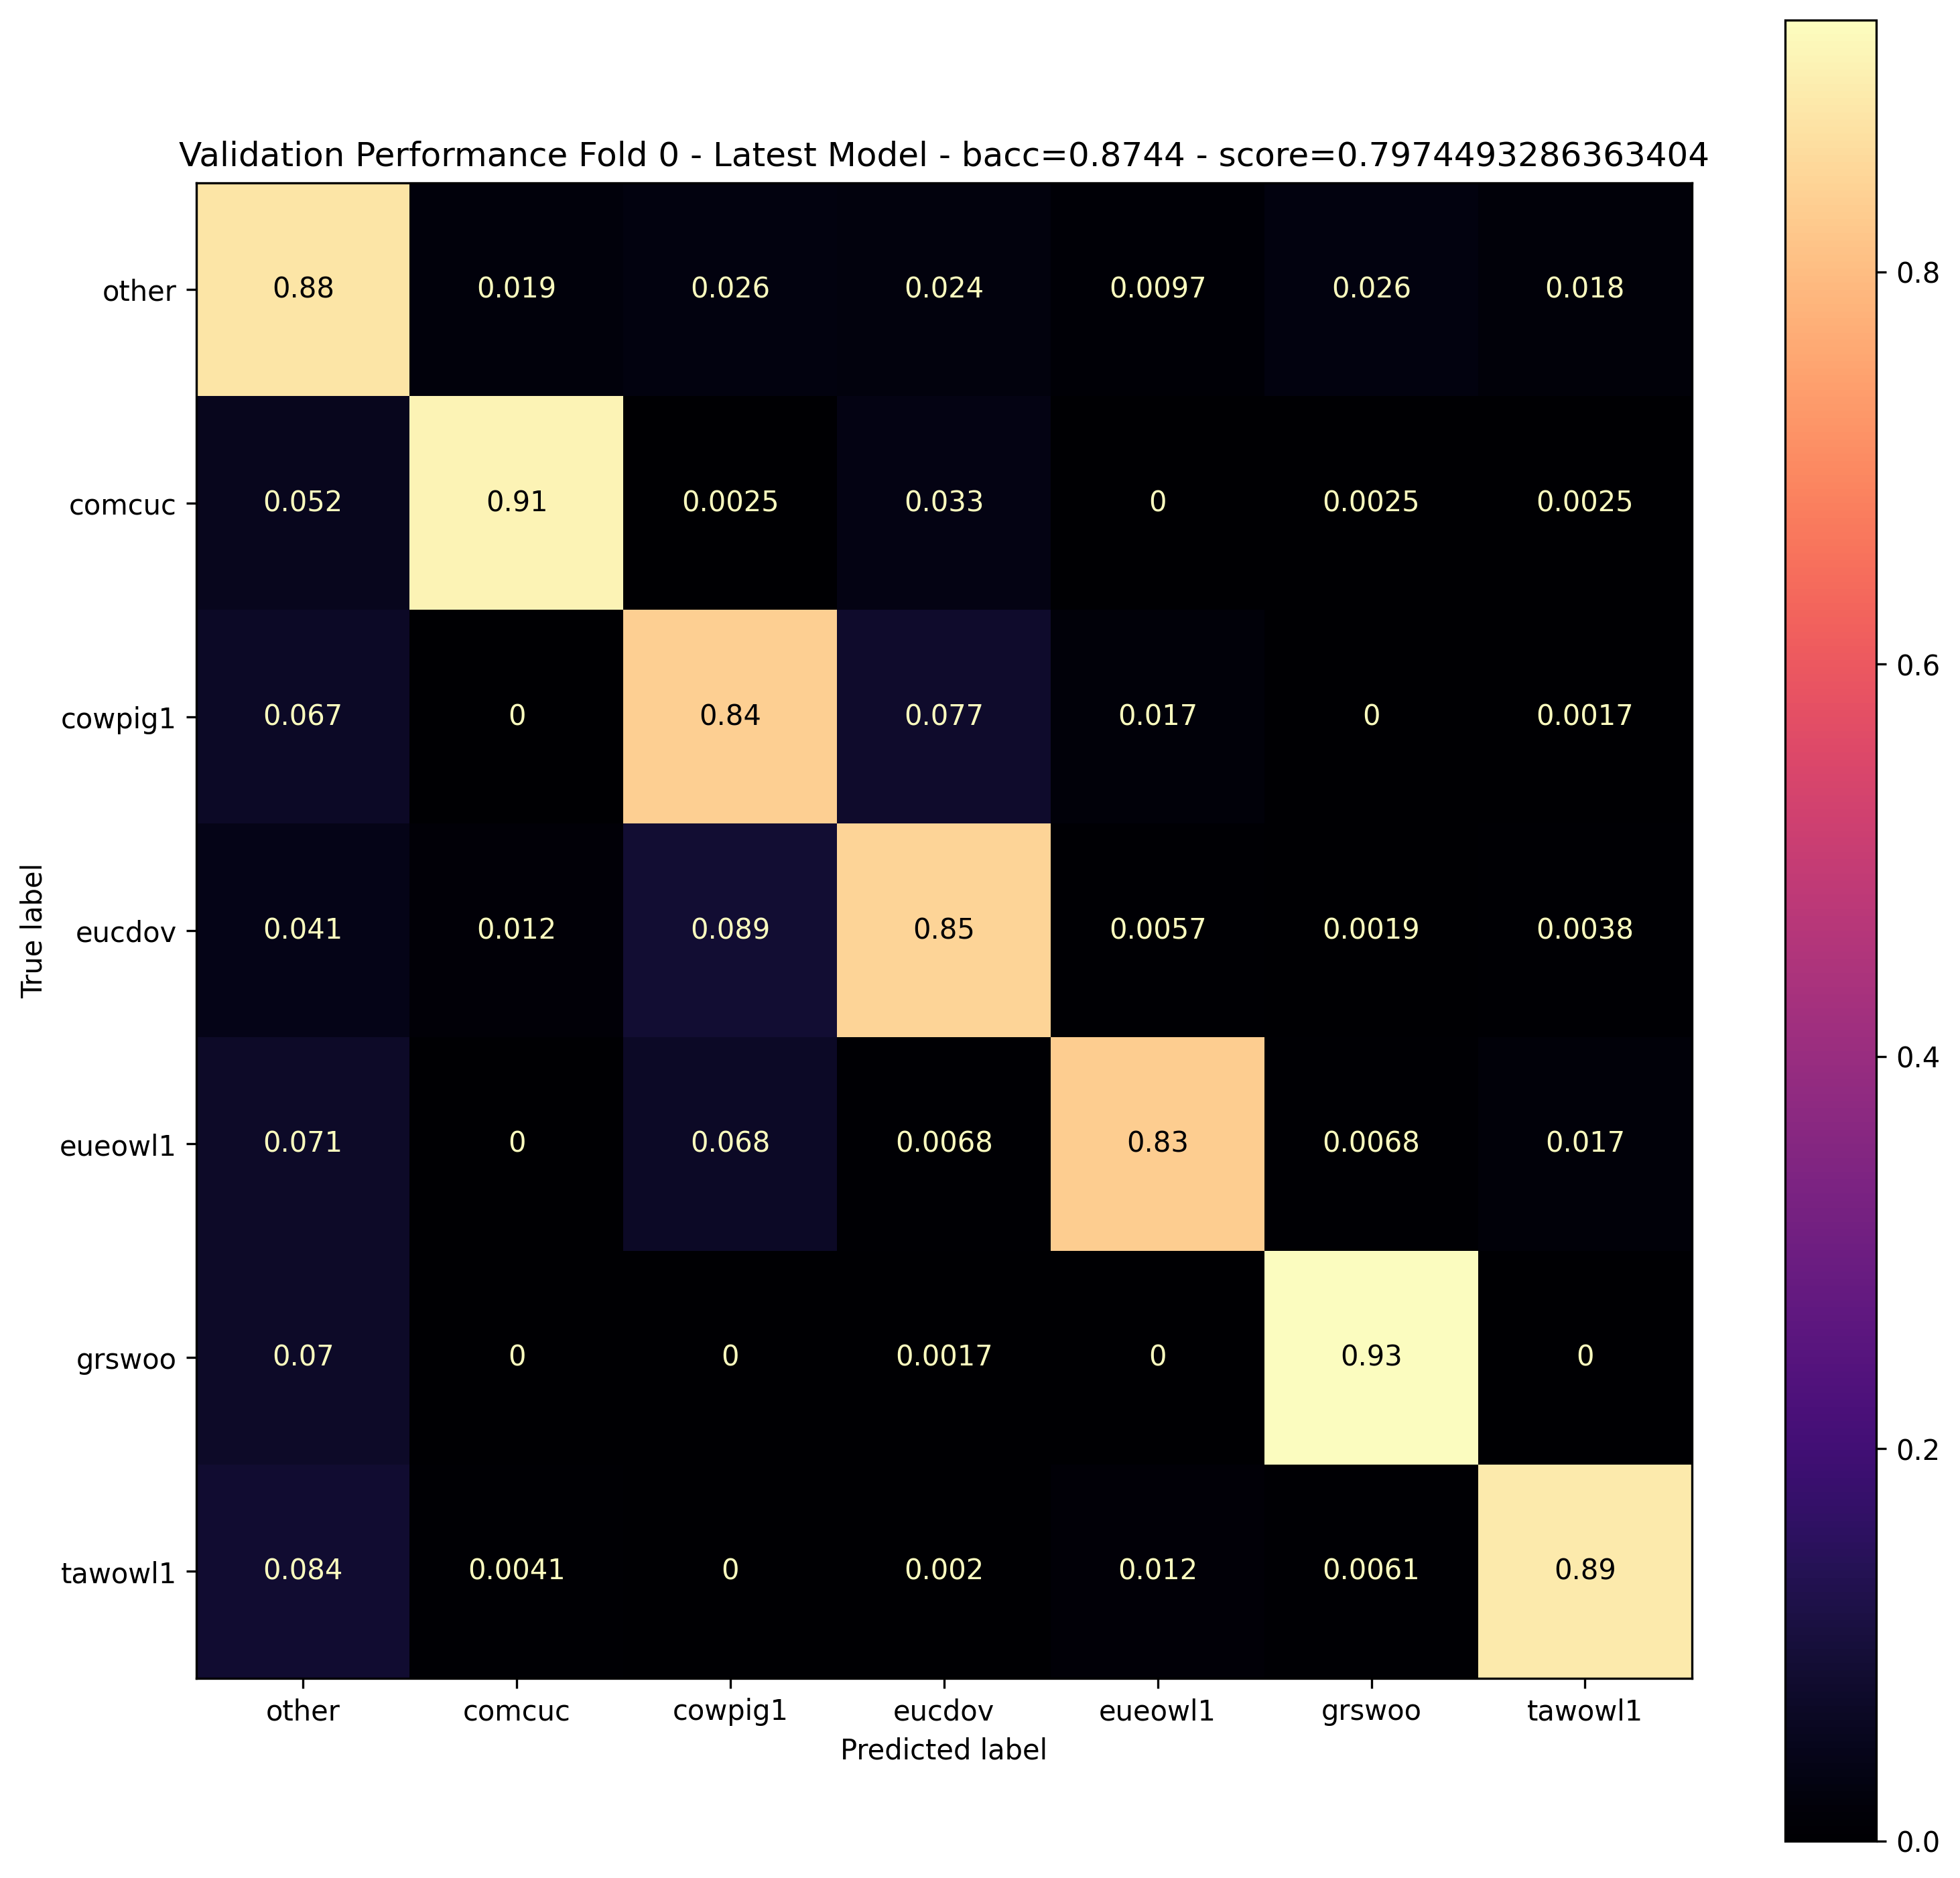

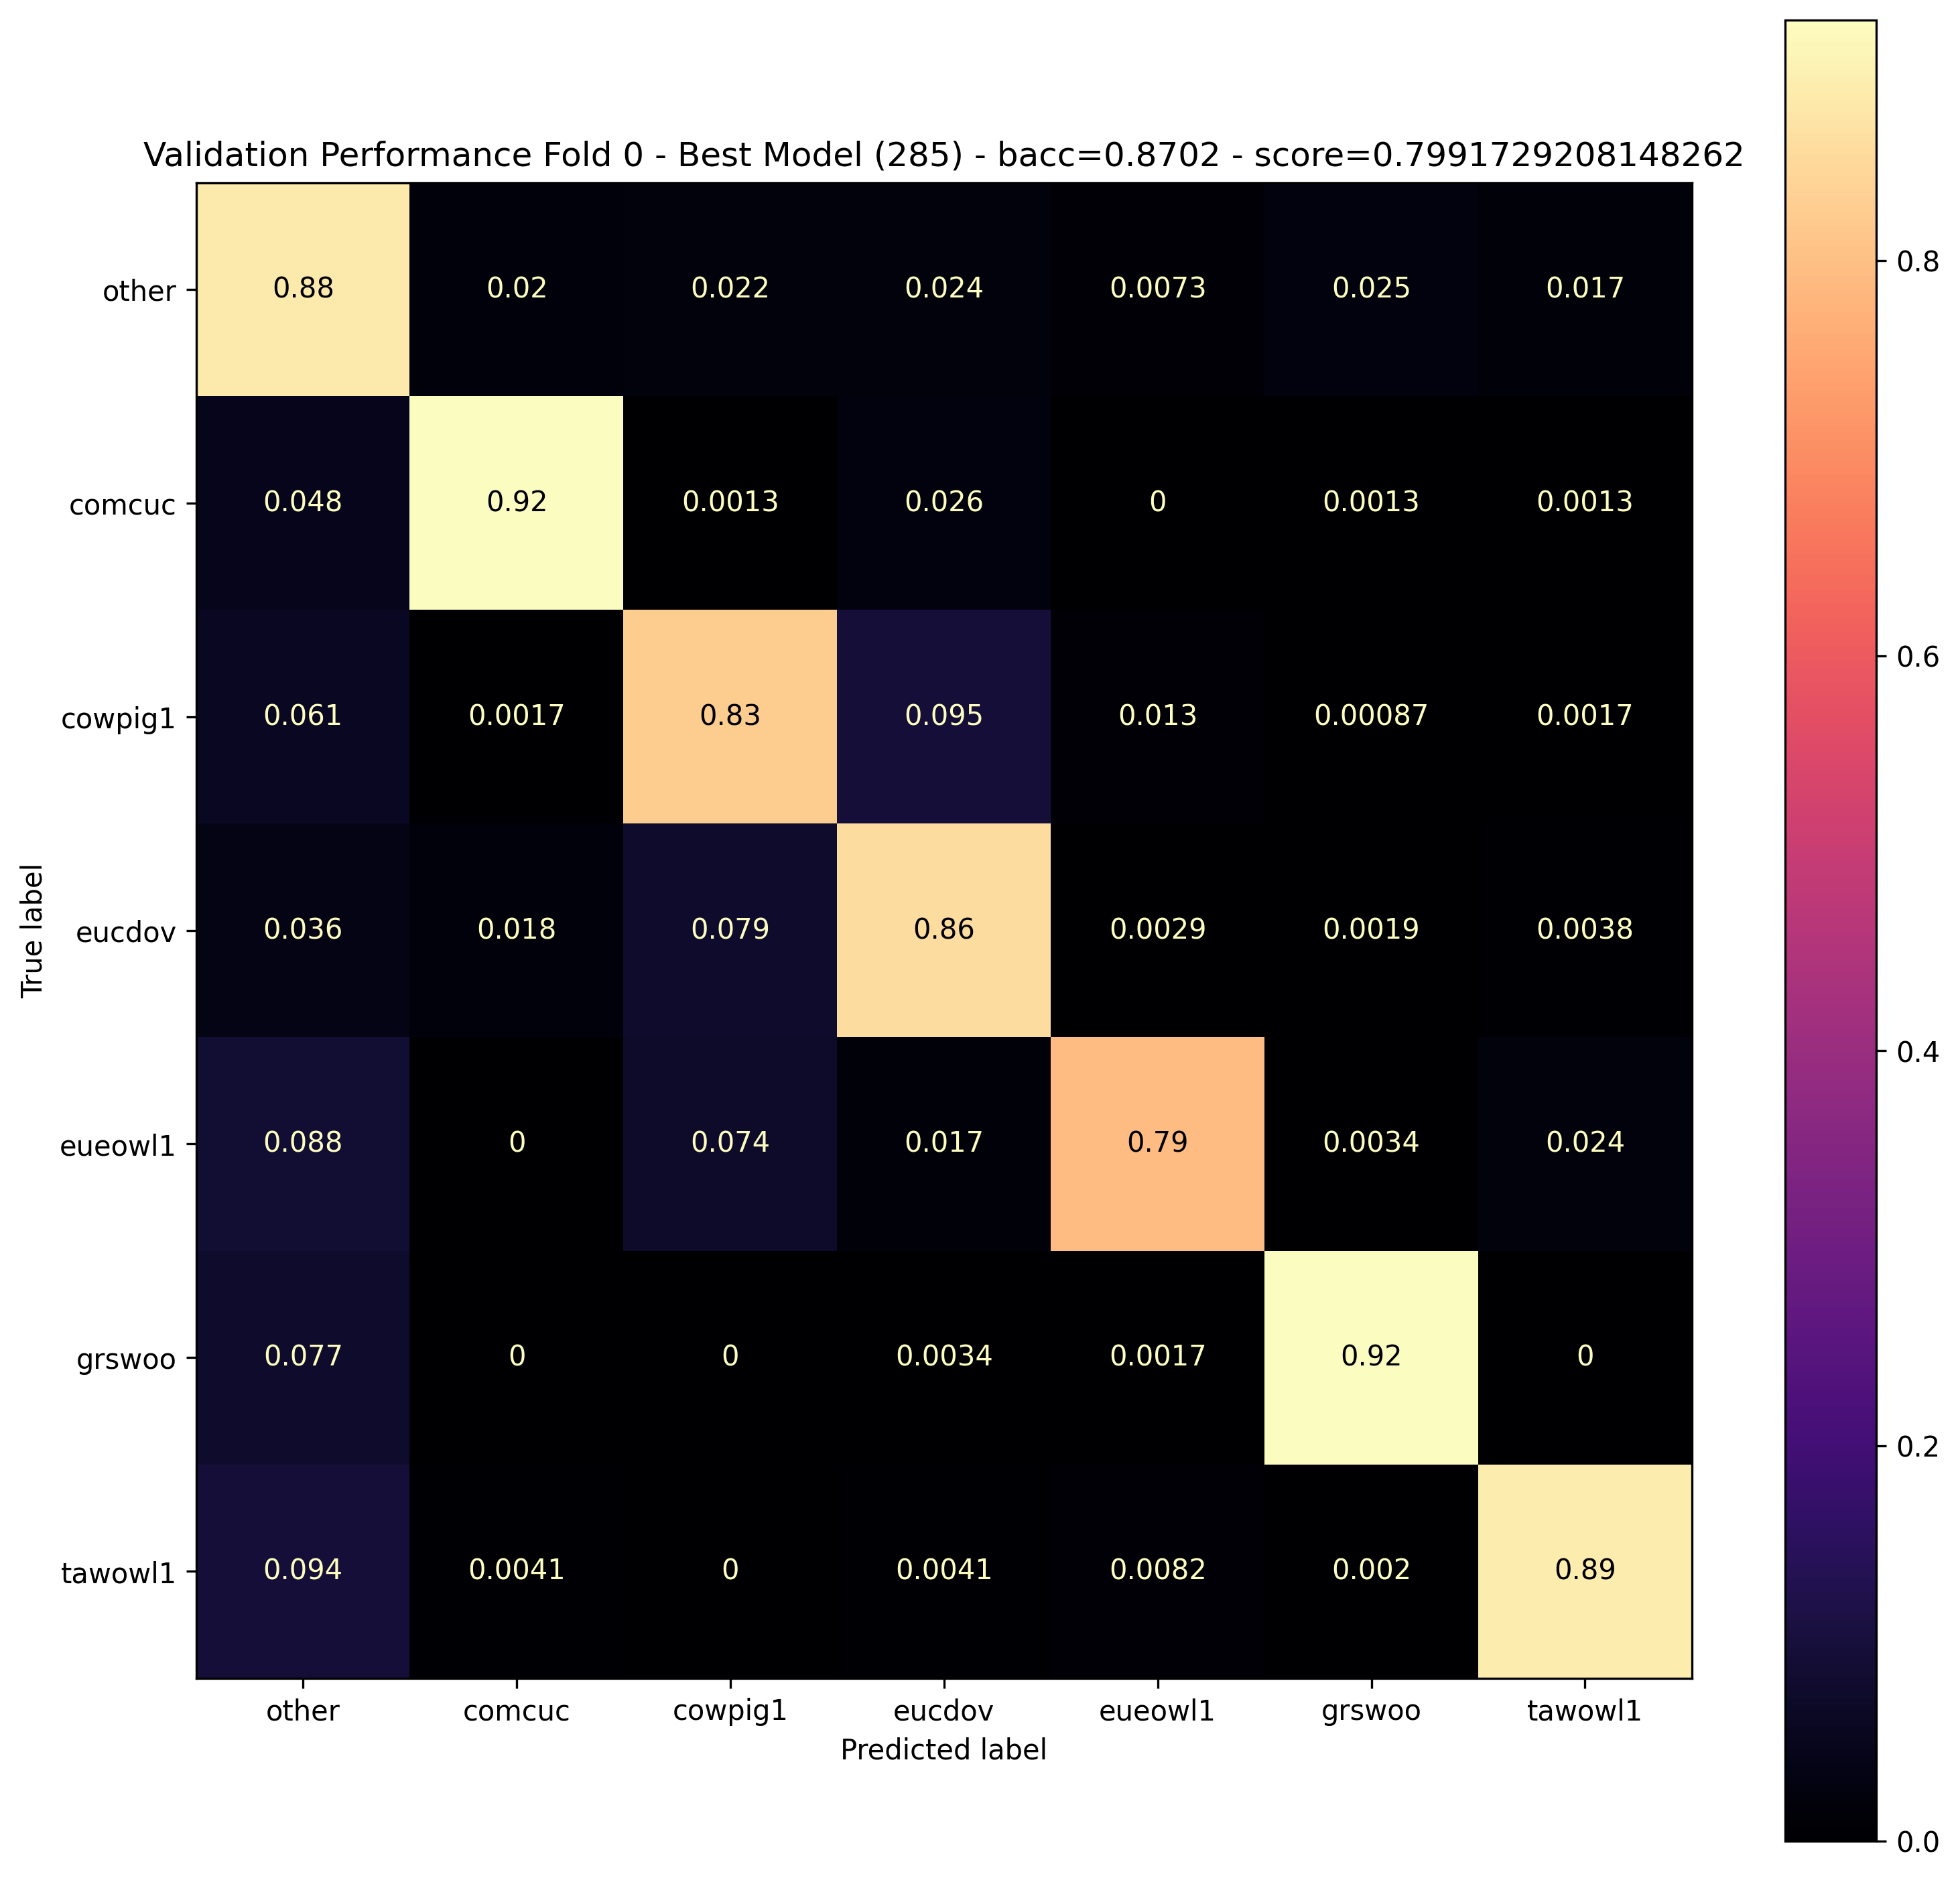

CV Folds:  12%|█████████████████████                                                                                                                                                   | 1/8 [01:23<09:47, 83.86s/it]

Saved model with scaler as "species_classifier cv2023-06-07_22.18 fold-0-best score=0.9378 "
Executing CV for fold 1
Training fold 1


#### Training ####
##################
AttentionClassifier with 57819 parameters, in_fnn: 41196, attention_stack: 14640, out_fnn: 1983
##################

train label counts = [74588, 5128, 7851, 7318, 1988, 4415, 3712]
loss weights = [0.74, 14.55, 6.33, 10.19, 37.52, 16.89, 20.09]

eval label counts = [10770, 705, 1103, 880, 336, 696, 510]
eval loss weights (theoretical) = [0.74, 15.28, 6.51, 12.24, 32.05, 15.47, 21.12]


Training Epoch   1/300: lr = 1.00E-03, epoch =     1, avg_loss = 0.000208, num_samples = 105000, num_correct = 13959, acc = 0.132943, bacc = 0.142166, score = -0.307187
Evaluation Epoch   1/300: epoch =     1, avg_loss = 0.000245, num_samples = 15000, num_correct =   880, acc = 0.058667, bacc = 0.142857, score = -0.337423
Training Epoch   2/300: lr = 1.00E-03, epoch =     2, avg_loss = 0.000207, num_samples = 105000, num_correct =  730

CV Folds:  12%|████████████████████▉                                                                                                                                                  | 1/8 [01:59<13:59, 119.88s/it]

Training Epoch 126/300: lr = 1.00E-03, epoch =   126, avg_loss = 0.000011, num_samples = 105000, num_correct = 93820, acc = 0.893524, bacc = 0.965255, score = 0.900264
Evaluation Epoch 126/300: epoch =   126, avg_loss = 0.000068, num_samples = 15000, num_correct = 12995, acc = 0.866333, bacc = 0.877607, score = 0.796926


KeyboardInterrupt: 

In [10]:
set_random_seed(43)

cv_training_hyper_parameters = create_training_hyper_parameters(
    num_epochs=300,
    initial_lr=1e-3,
    lr_scheduler_milestones=[30, 100, 250],
    lr_scheduler_gamma=0.75,
)

cv_models_with_scalers, cv_folds_metrics, best_models_metrics = train_model_with_cv(
    lambda: AttentionClassifier(ac_hyper_parameters),
    cv_training_hyper_parameters, 
    combined_ds,
    n_folds=8,
    device=device,
    save_models='best',
    model_saving_name='species_classifier',
)


## Metrics ##
print(
'''

#################
#### Metrics ####
#################

'''
)

cv_average_best_best_models_eval_metrics = calculate_average_metrics([m[1] for m in best_models_metrics])
print(f'{cv_average_best_best_models_eval_metrics = } \n\n')

cv_final_epoch_avg_train_metrics, cv_final_epoch_avg_eval_metrics = calculate_average_metrics_for_final_epoch_of_folds(cv_folds_metrics)
print(f'{cv_final_epoch_avg_train_metrics = }')
print(f'{cv_final_epoch_avg_eval_metrics  = }')

cv_avg_epoch_train_metrics = calculate_average_metrics_per_epoch(cv_folds_metrics)

rows = []
for fold_nr, fold_metrics in enumerate(cv_folds_metrics):
    for epoch_nr, (train_metrics, eval_metrics) in enumerate(fold_metrics):
        rows.append({
            'cv_fold': fold_nr,
            'epoch': epoch_nr,
            'type': 'CV Train BACC',
            'bacc': train_metrics.bacc,
        })
        if eval_metrics is not None:
            rows.append({
                'cv_fold': fold_nr,
                'epoch': epoch_nr,
                'type': 'CV Eval BACC',
                'bacc': eval_metrics.bacc,
            })

cv_metrics_df = pd.DataFrame(rows)

# Plots

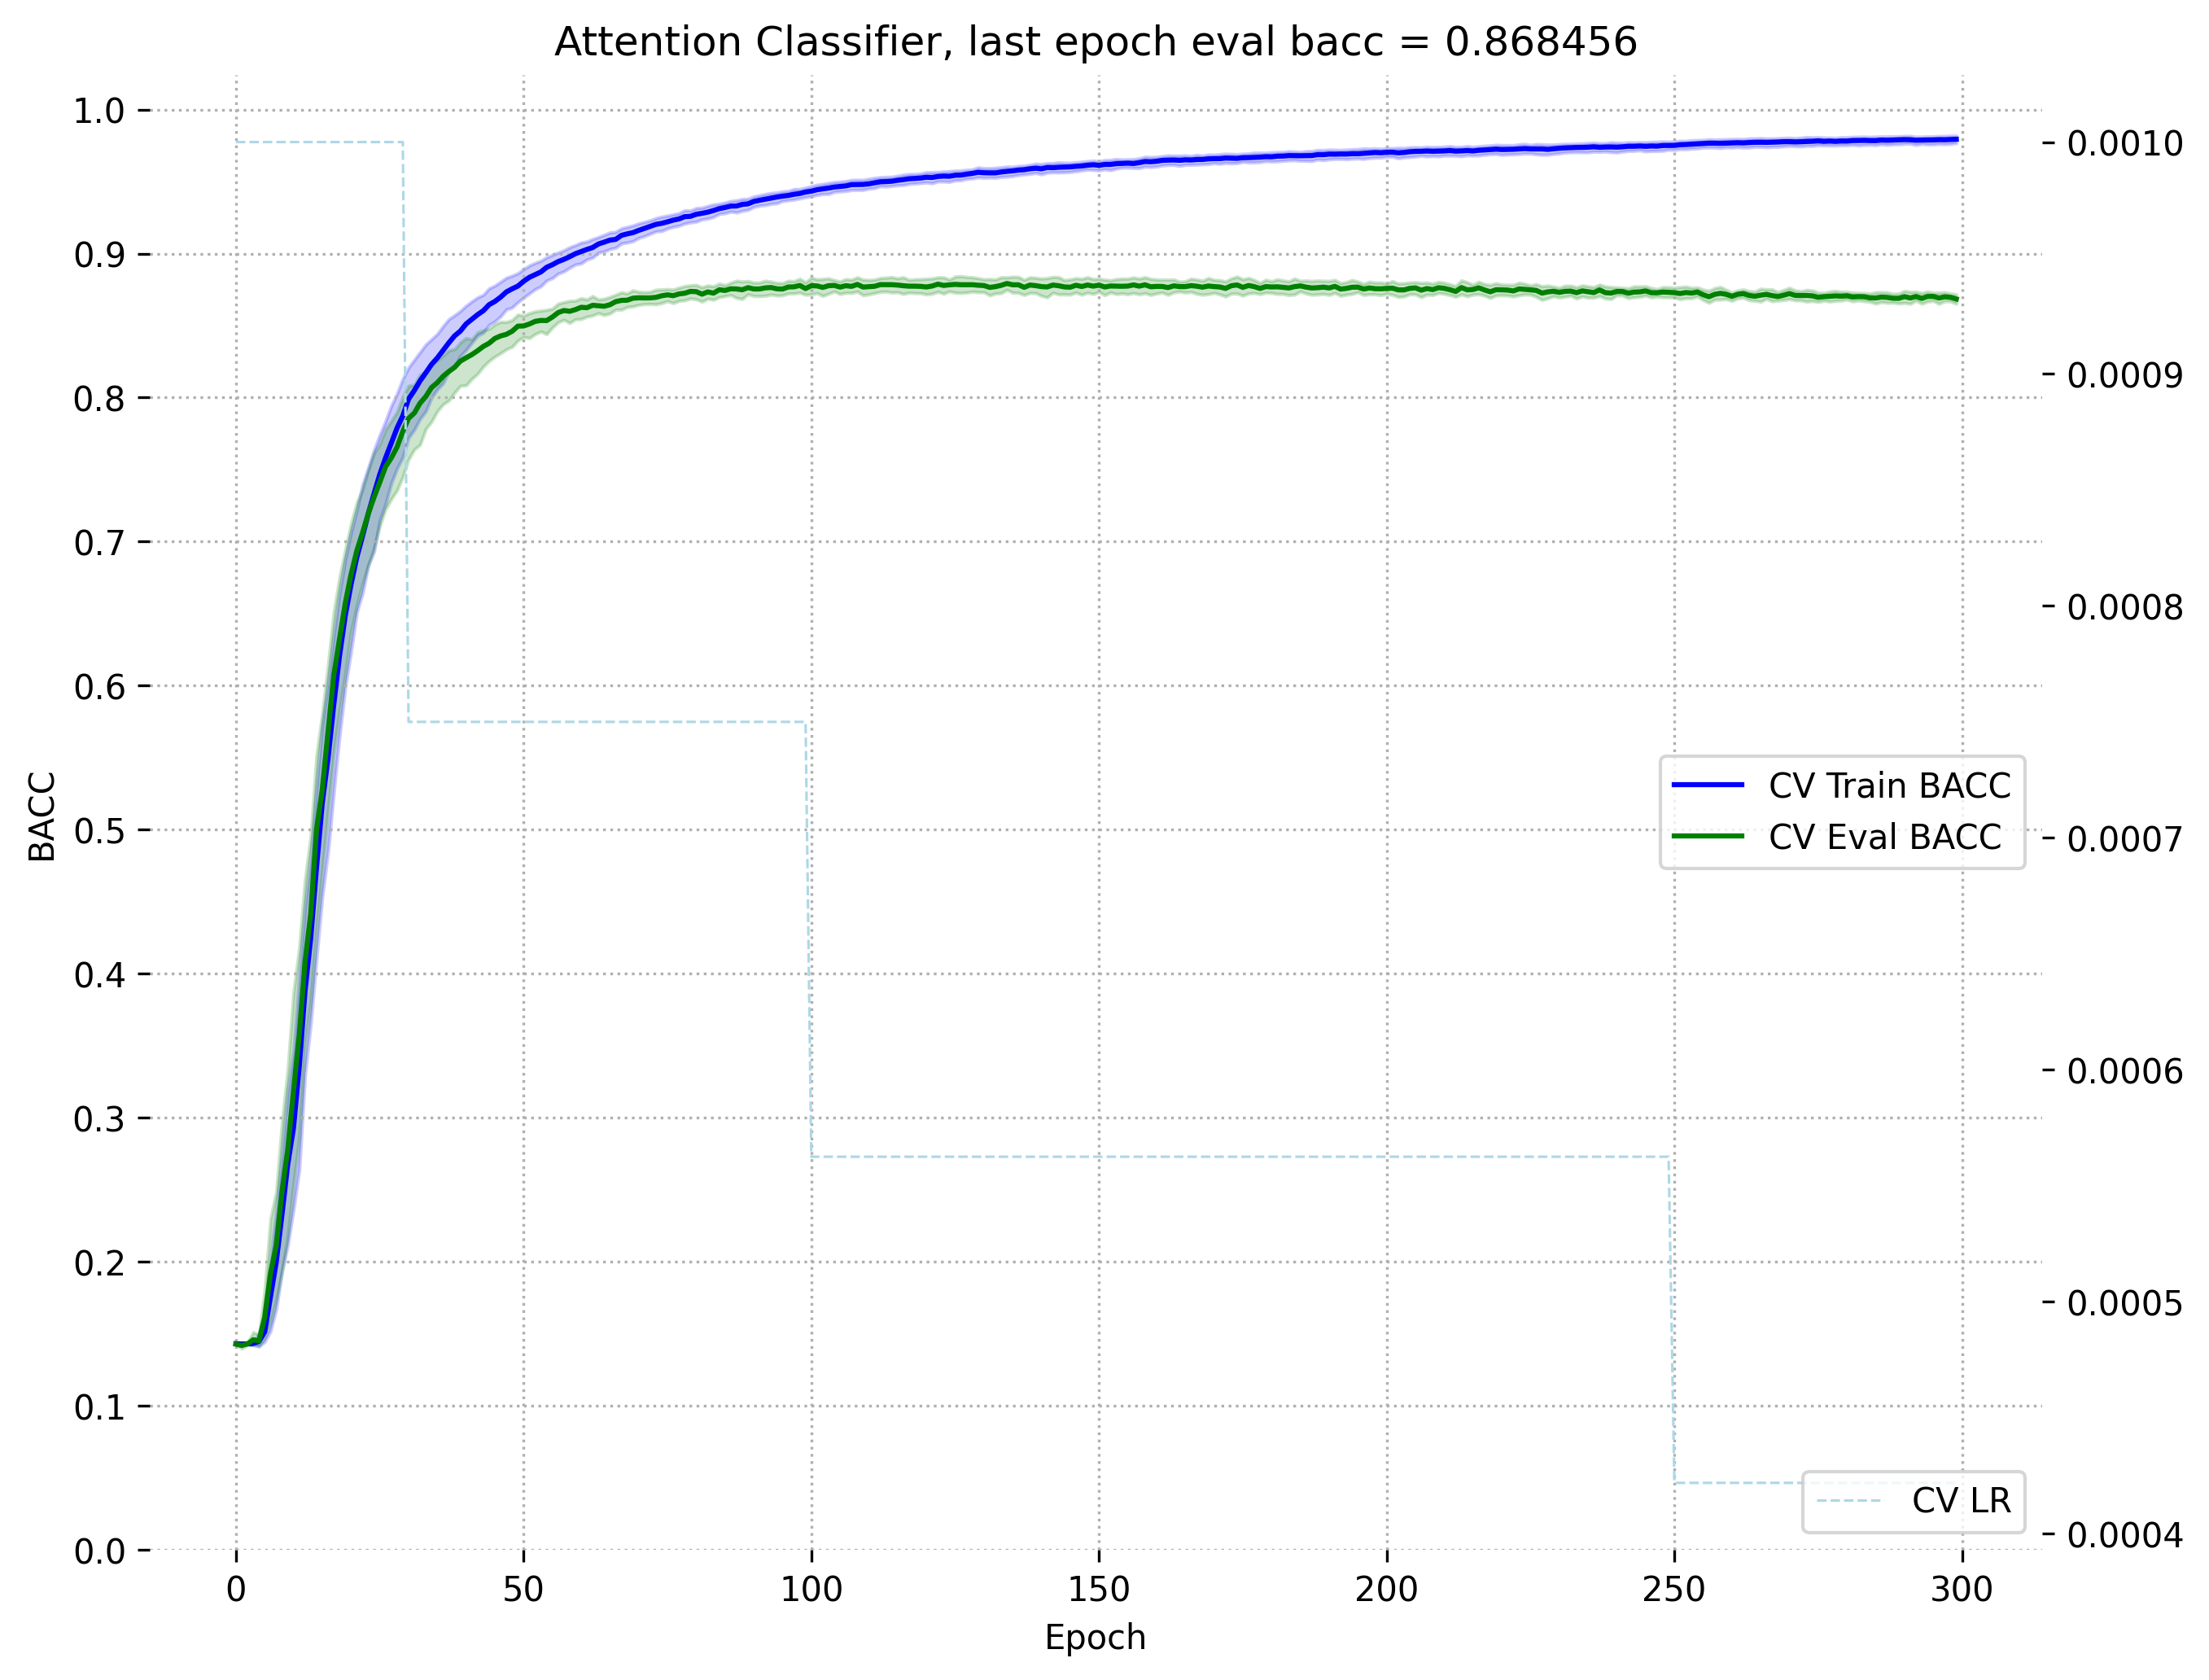

In [25]:
def create_lrs_over_epochs(training_hyper_parameters: TrainingHyperParameters) -> list[float]:
    lrs: list[float] = []
    
    lr = training_hyper_parameters.lr
    for epoch_nr in range(training_hyper_parameters.num_epochs):
        if epoch_nr in training_hyper_parameters.lr_scheduler_milestones:
            lr *= training_hyper_parameters.lr_scheduler_gamma
        lrs.append(lr)
    return lrs
    

def plot_baccs_over_epochs(title: str):
    fig, ax = plt.subplots(1, 1, figsize=(10, 8), dpi=300)
    
    cv_epoch_range = np.arange(0, cv_training_hyper_parameters.num_epochs)
    
    sns.lineplot(data=cv_metrics_df, x='epoch', y='bacc', hue='type', ax=ax, palette=['blue', 'green'])
    
    twin_ax = ax.twinx()
    lr_plots_kwargs = {
        'ls': '--',
        'lw': 0.75
    }
    twin_ax.plot(cv_epoch_range, create_lrs_over_epochs(cv_training_hyper_parameters), label='CV LR', c='lightblue', **lr_plots_kwargs)

    ax.set(
        title=title,
        xlabel='Epoch',
        ylabel='BACC',
        yticks=[x * 0.1 for x in range(11)]
    )

    ax.grid(ls=':')
    ax.legend(loc='center right')
    twin_ax.legend(loc='lower right')

    for spine in ['top', 'right', 'bottom', 'left']:
        ax.spines[spine].set_visible(False)
        twin_ax.spines[spine].set_visible(False)

    plt.show()

average_last_epoch_eval_bacc = cv_metrics_df.query('type == "CV Eval BACC"').groupby('epoch').mean().iloc[-1]['bacc']
plot_baccs_over_epochs(f'Attention Classifier, last epoch eval bacc = {average_last_epoch_eval_bacc:6f}')